<a href="https://colab.research.google.com/github/AAdewunmi/Breast-Cancer-Risk-Prediction-Project/blob/main/Breast_Cancer_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Breast Cancer Prediction Project

We will build a Deep Learning Model that is to be trained on breast cancer autopsy image dataset to predict if a person has breast cancer and if it is benigh or malign.

We will be using DenseNet-201 which is a convolution neural network that is 201 layers deep. We can load a pretrained version of the network or we can also retrain the model, which is what we are doing in this project.

We will then implement our very own website that will be built using Django framwork and host it on AWS.

In [1]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install core ML/CV dependencies

!pip install numpy pandas matplotlib tensorflow keras opencv-python Pillow scikit-learn scipy tqdm

In [3]:
# Installs all core libraries required for the model training script,
# including TensorFlow/Keras, NumPy, Pandas, scikit-learn, OpenCV (cv2),
# and Pillow.

import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow
from keras import layers
from tensorflow.keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


In [4]:
# Implement Dataset_loader and init benign/malign datasets

import os
from typing import Tuple, Union, List

import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm


def Dataset_loader(DIR: str, RESIZE: Union[int, Tuple[int, int]], sigmaX: float = 0.0) -> np.ndarray:
    """
    Load all PNG images from a directory, convert them to RGB, resize, and return a NumPy array.

    Parameters
    ----------
    DIR : str
        Directory containing images. Only files with a .png extension (case-insensitive) are loaded.
    RESIZE : int | tuple[int, int]
        Target size. If an int, images are resized to (RESIZE, RESIZE).
        If a tuple, interpret as (width, height) per OpenCV's convention.
    sigmaX : float, optional
        Standard deviation for Gaussian blur. If > 0, apply cv2.GaussianBlur; default is 0 (no blur).

    Returns
    -------
    np.ndarray
        Array of shape (N, H, W, 3) in uint8 RGB, where N is the number of images.
        If the directory has no PNGs, returns an empty array with shape (0, H, W, 3).

    Raises
    ------
    FileNotFoundError
        If the provided directory does not exist.
    ValueError
        If RESIZE is a tuple with non-positive values.

    Notes
    -----
    - Uses PIL to read and ensure RGB; uses OpenCV for resizing (INTER_AREA).
    - Processing order is deterministic (alphabetical file name sort).
    - Consider renaming to `load_dataset` for PEP 8 compliance in future refactors.

    Examples
    --------
    >>> imgs = Dataset_loader("/path/to/benign", 224)
    >>> imgs.shape
    (N, 224, 224, 3)
    """
    if not os.path.isdir(DIR):
        raise FileNotFoundError(f"Directory not found: {DIR}")

    # Normalize RESIZE into an (width, height) tuple for OpenCV.
    if isinstance(RESIZE, int):
        target_size: Tuple[int, int] = (RESIZE, RESIZE)
    else:
        if len(RESIZE) != 2 or RESIZE[0] <= 0 or RESIZE[1] <= 0:
            raise ValueError("RESIZE tuple must be (width, height) with positive integers.")
        target_size = (int(RESIZE[0]), int(RESIZE[1]))

    # Collect .png files only (case-insensitive), sorted for reproducibility
    entries: List[str] = sorted(os.listdir(DIR))
    png_paths = [
        os.path.join(DIR, name)
        for name in entries
        if os.path.splitext(name)[1].lower() == ".png"
    ]

    # Early return with empty (0, H, W, 3) if no PNGs found
    if not png_paths:
        return np.empty((0, target_size[1], target_size[0], 3), dtype=np.uint8)

    images = []
    for path in tqdm(png_paths, desc=f"Loading {os.path.basename(DIR) or DIR}"):
        # Read with PIL, enforce RGB
        rgb = np.asarray(Image.open(path).convert("RGB"))
        # Resize with OpenCV (expects (width, height))
        resized = cv2.resize(rgb, target_size, interpolation=cv2.INTER_AREA)
        # Optional blur for preprocessing
        if sigmaX and sigmaX > 0:
            resized = cv2.GaussianBlur(resized, ksize=(0, 0), sigmaX=sigmaX)
        images.append(resized.astype(np.uint8))

    return np.stack(images, axis=0)

# pass RESIZE and fix the typo in the second path
benign = Dataset_loader(
    "drive/MyDrive/Colab Notebooks/Breast-Cancer-Risk-Prediction/data/benign",
    224
)
malign = Dataset_loader(
    "drive/MyDrive/Colab Notebooks/Breast-Cancer-Risk-Prediction/data/malign",
    224
)


Loading malign: 100%|██████████| 127/127 [00:07<00:00, 17.81it/s]


In [5]:
"""
Notebook-friendly unit tests for `Dataset_loader`.

Usage
-----
1) Define `Dataset_loader` in a previous cell (or ensure `src/dataloader.py` is importable).
2) Run this cell. You'll get a unittest report in the output.

Notes
-----
- Uses `unittest` (no external CLI needed).
- Creates temporary images and folders; cleans up after itself.
- Mirrors the original pytest assertions closely.
"""

import os
import sys
import unittest
import tempfile
from pathlib import Path

import numpy as np
from PIL import Image

# Optional: If you're in a fresh Colab and missing deps used by Dataset_loader,
# you may need to install them in a separate cell:
# !pip install pillow opencv-python tqdm

# Try to access Dataset_loader from the current notebook scope;
# if not present, attempt import from src.dataloader.
try:
    Dataset_loader  # type: ignore  # noqa: F401
except NameError:
    try:
        from src.dataloader import Dataset_loader  # type: ignore
    except Exception as e:
        raise RuntimeError(
            "Dataset_loader not found. Define it in a previous cell or ensure src/dataloader.py is importable."
        ) from e


def _make_img(path: Path, size=(30, 20), color=(120, 60, 30)):
    """
    Create a simple RGB image and save it to `path` (PNG or JPG based on extension).

    Parameters
    ----------
    path : Path
        Destination file path (extension determines format).
    size : tuple[int, int]
        (width, height) of the image to create.
    color : tuple[int, int, int]
        RGB color fill for the created image.
    """
    img = Image.new("RGB", size, color)
    img.save(path)


class DatasetLoaderNotebookTests(unittest.TestCase):
    """Unit tests for `Dataset_loader` adapted for a single Colab cell."""

    def setUp(self):
        # Fresh temp directory for each test
        self._tmpdir = tempfile.TemporaryDirectory()
        self.tmp = Path(self._tmpdir.name)

    def tearDown(self):
        # Cleanup temp directory
        self._tmpdir.cleanup()

    def test_load_pngs_and_resize(self):
        d = self.tmp / "images"
        d.mkdir(parents=True, exist_ok=True)

        # Two PNGs (including uppercase extension) and one JPG (ignored)
        _make_img(d / "a.png", size=(50, 40), color=(255, 0, 0))
        _make_img(d / "b.PNG", size=(40, 50), color=(0, 255, 0))  # case-insensitive
        _make_img(d / "c.jpg", size=(60, 60), color=(0, 0, 255))  # should be ignored

        arr = Dataset_loader(str(d), 224)
        self.assertIsInstance(arr, np.ndarray)
        self.assertEqual(arr.shape, (2, 224, 224, 3))
        self.assertEqual(arr.dtype, np.uint8)

    def test_resize_tuple_width_height(self):
        d = self.tmp / "imgs"
        d.mkdir(parents=True, exist_ok=True)

        _make_img(d / "x.png", size=(10, 10))
        _make_img(d / "y.png", size=(20, 5))

        # (width, height) per OpenCV convention
        arr = Dataset_loader(str(d), (120, 80))
        self.assertEqual(arr.shape, (2, 80, 120, 3))

    def test_nonexistent_dir_raises(self):
        with self.assertRaises(FileNotFoundError):
            Dataset_loader(str(self.tmp / "no_such_dir"), 224)

    def test_empty_dir_returns_empty_array(self):
        d = self.tmp / "empty"
        d.mkdir(parents=True, exist_ok=True)

        arr = Dataset_loader(str(d), 64)
        self.assertIsInstance(arr, np.ndarray)
        self.assertEqual(arr.shape, (0, 64, 64, 3))


# Run tests when the cell executes
unittest.main(argv=[""], verbosity=2, exit=False)

test_empty_dir_returns_empty_array (__main__.DatasetLoaderNotebookTests.test_empty_dir_returns_empty_array) ... ok
Loading images: 100%|██████████| 2/2 [00:00<00:00, 1287.98it/s]
ok
test_nonexistent_dir_raises (__main__.DatasetLoaderNotebookTests.test_nonexistent_dir_raises) ... ok
Loading imgs: 100%|██████████| 2/2 [00:00<00:00, 1977.98it/s]
ok

----------------------------------------------------------------------
Ran 4 tests in 0.025s

OK


In [6]:
# Add class label arrays for benign/malign

benign_label = np.zeros(len(benign))
malign_label = np.ones(len(malign))

In [7]:
# Combine images and labels into X/Y

X = np.concatenate((benign,malign), axis=0)
Y = np.concatenate((benign_label, malign_label), axis=0)

In [8]:
# Shuffle dataset and one-hot encode labels

s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]
Y = to_categorical(Y, num_classes=2)

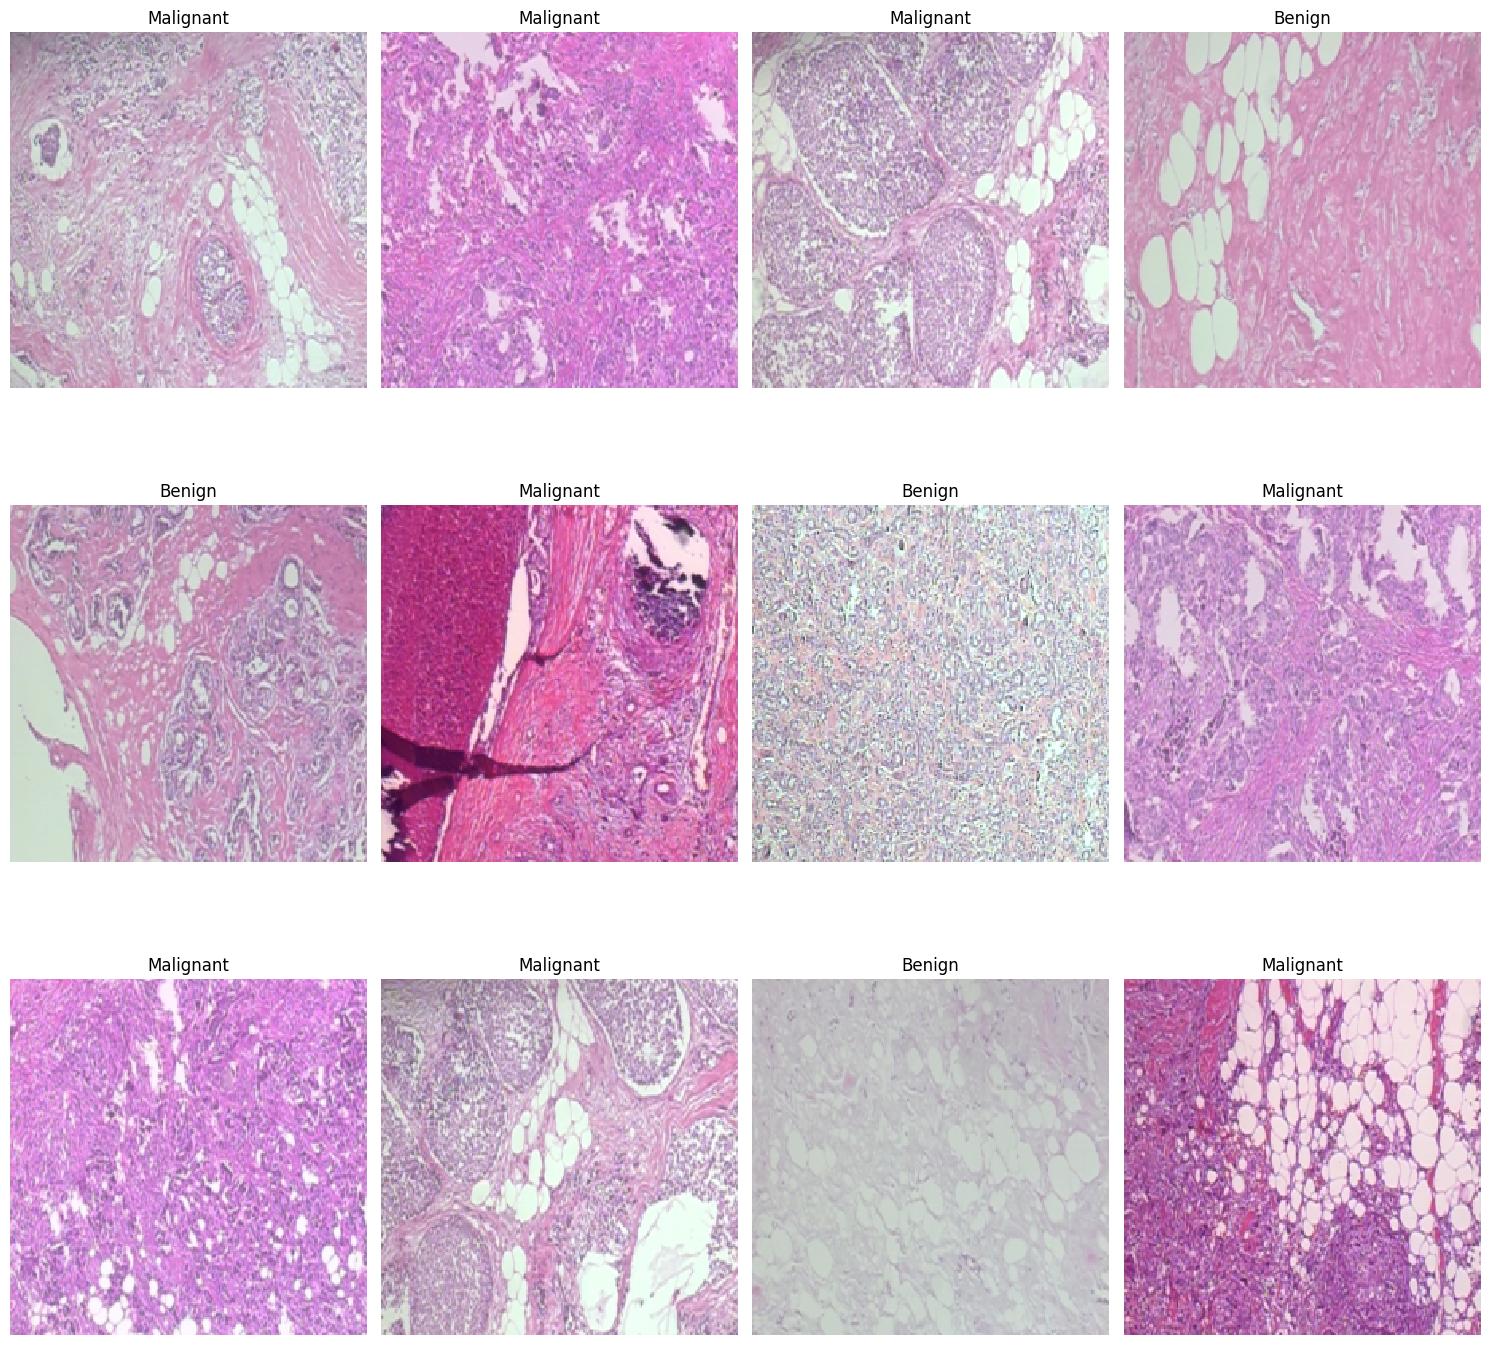

In [11]:
# Train/val split + grid preview

# Helpers + plotting

from __future__ import annotations
from typing import Iterable, Optional, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def split_dataset(
    X: np.ndarray,
    Y: np.ndarray,
    test_size: float = 0.20,
    random_state: int = 42,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split images and labels into train/validation sets.

    Parameters
    ----------
    X : np.ndarray
        Image array of shape (N, H, W, C).
    Y : np.ndarray
        Label array of shape (N,) for integer labels or (N, K) for one-hot labels.
    test_size : float, optional
        Fraction for validation split. Default is 0.20.
    random_state : int, optional
        Random seed for reproducibility. Default is 42.

    Returns
    -------
    x_train, x_val, y_train, y_val : tuple of np.ndarray
        Train/validation splits matching scikit-learn's `train_test_split` behavior.
    """
    return train_test_split(X, Y, test_size=test_size, random_state=random_state, shuffle=True)


def plot_image_grid(
    x: np.ndarray,
    y: np.ndarray,
    rows: int = 3,
    columns: int = 4,
    figsize: Tuple[int, int] = (15, 15),
    class_names: Optional[Sequence[str]] = ("Benign", "Malignant"),
    indices: Optional[Iterable[int]] = None,
    shuffle: bool = False,
    random_state: Optional[int] = None,
    interpolation: str = "nearest",
):
    """
    Plot a grid of sample images with titles derived from labels.

    Works with integer labels or one-hot labels.

    Parameters
    ----------
    x : np.ndarray
        Image array of shape (N, H, W, C) in RGB order.
    y : np.ndarray
        Labels as integers (N,) or one-hot encoded (N, K).
    rows : int, optional
        Number of rows in the grid. Default is 3.
    columns : int, optional
        Number of columns in the grid. Default is 4.
    figsize : (int, int), optional
        Matplotlib figure size. Default is (15, 15).
    class_names : sequence of str or None, optional
        Class names used for titles. If None, numeric labels are shown.
        Length should match number of classes when y is one-hot.
    indices : iterable of int or None, optional
        Exact sample indices to plot. If None, the function selects the first `rows*columns`
        after optional shuffling.
    shuffle : bool, optional
        If True and `indices` is None, randomly permute the dataset before selecting samples.
    random_state : int or None, optional
        Seed for shuffling when `shuffle=True`.
    interpolation : str, optional
        Matplotlib interpolation mode for imshow. Default is "nearest".

    Returns
    -------
    fig : matplotlib.figure.Figure
        The created Matplotlib figure.
    used_indices : np.ndarray
        The indices of samples displayed (length == rows * columns).

    Raises
    ------
    ValueError
        If there are not enough samples to fill the grid or shapes are incompatible.

    Notes
    -----
    - If labels are one-hot (N, K), the function uses argmax along axis=1.
    - Axis ticks are hidden for a cleaner gallery view.
    """
    if x.ndim != 4 or x.shape[0] != y.shape[0]:
        raise ValueError(f"Incompatible shapes: x{tuple(x.shape)} y{tuple(y.shape)}")

    n = x.shape[0]
    k = rows * columns
    if k <= 0:
        raise ValueError("rows * columns must be positive.")

    # Normalize labels to integer class ids
    y_int = y
    if y.ndim == 2:
        y_int = np.argmax(y, axis=1)
    elif y.ndim != 1:
        raise ValueError("y must be shape (N,) for integer labels or (N, K) for one-hot.")

    # Determine which indices to plot
    if indices is not None:
        used_indices = np.array(list(indices), dtype=int)
    else:
        used_indices = np.arange(n)
        if shuffle:
            rng = np.random.default_rng(random_state)
            rng.shuffle(used_indices)
        used_indices = used_indices[:k]

    if used_indices.size < k:
        raise ValueError(f"Not enough samples to fill the grid: need {k}, have {used_indices.size}")

    # Build the figure
    fig = plt.figure(figsize=figsize)
    for j, idx in enumerate(used_indices[:k], start=1):
        ax = fig.add_subplot(rows, columns, j)
        ax.imshow(x[idx], interpolation=interpolation)
        ax.axis("off")

        label_id = int(y_int[idx])
        if class_names is not None and 0 <= label_id < len(class_names):
            ax.set_title(class_names[label_id])
        else:
            ax.set_title(str(label_id))

    plt.tight_layout()
    return fig, used_indices

x_train, x_val, y_train, y_val = split_dataset(X, Y, test_size=0.2, random_state=42)
fig, used = plot_image_grid(x_train, y_train, rows=3, columns=4, class_names=("Benign","Malignant"))
plt.show()
